## Anomaly Detection Demo using MyTorch

This notebook demonstrates anomaly detection using MyTorch instead of PyTorch.

- MyTorch provides all the features of PyTorch.
- The code below is identical to PyTorch.
- MyTorch offers transparent access to cloud GPUs with zero code changes.
- Simply pip install `mytorch-ai` instead of `torch`.
- But first, one more step: register with MyTorch.net and get an access token.
- Put that token into a file named ~/.mytorch (in your home directory).

> echo "token=xxx" > ~/.mytorch

### Make sure you set up your environment correctly:

> python3 -m venv ~/venv_mytorch  
> source ~/venv_mytorch/bin/activate  
> pip install --upgrade pip  
> pip install --upgrade mytorch-ai

To launch this notebook, do this:

> git clone https://github.com/mytorch-ai/examples.git  
> pip install jupyter ipykernel matplotlib numpy scikit-learn  
> python -m ipykernel install --user --name=mytorch --display-name="Python (mytorch)"  
> jupyter notebook  

Follow the instructions in your terminal to open your browser to the Jupyter page.  
Select the /examples/jupyter/water_leak_detection.ipynb file.  
Once open, select the "Python (mytorch)" kernel.  

In [1]:
# Step 1 : Import Libraries and verify connection to MyTorch server.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f"MyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"*** Using GPU\t: {torch.cuda.get_device_name()} ***")
else:
    print("*** No GPU available ***")

MyTorch version: 0.4.5


INFO - Connecting to MyTorch server proxy.mytorch.net:55553


*** Using GPU	: Tesla P100-PCIE-16GB ***


In [2]:
# Step 2 : Generate water usage data (normal and anomalous).

def generate_water_usage_data(n_samples=1000, n_features=24, contamination=0.1):
    n_anomalies = max(int(n_samples * contamination), 1)
    n_normals = n_samples - n_anomalies

    # Normal data: realistic variation, clipped to avoid negative values
    normal_usage = np.random.normal(loc=2.0, scale=1.5, size=(n_normals, n_features))
    normal_usage = np.clip(normal_usage, a_min=0, a_max=None)

    # Anomalous data: normal baseline + realistic burst spikes
    anomaly_usage = []
    for _ in range(n_anomalies):
        sample = np.random.normal(loc=2.0, scale=1.0, size=n_features)

        # Add 1–3 spike events with localized burst shape
        n_spikes = np.random.randint(1, 4)
        for _ in range(n_spikes):
            center = np.random.randint(2, n_features - 2)
            height = np.random.uniform(20, 30)

            sample[center] = height
            sample[center - 1] += height * 0.3
            sample[center + 1] += height * 0.3
            sample[center - 2] += height * 0.1
            sample[center + 2] += height * 0.1

        sample = np.clip(sample, a_min=0, a_max=None)
        anomaly_usage.append(sample)

    X = np.vstack([normal_usage, anomaly_usage])
    y = np.hstack([np.zeros(n_normals), np.ones(n_anomalies)])
    return X, y

# Generate data
X, y_true = generate_water_usage_data()

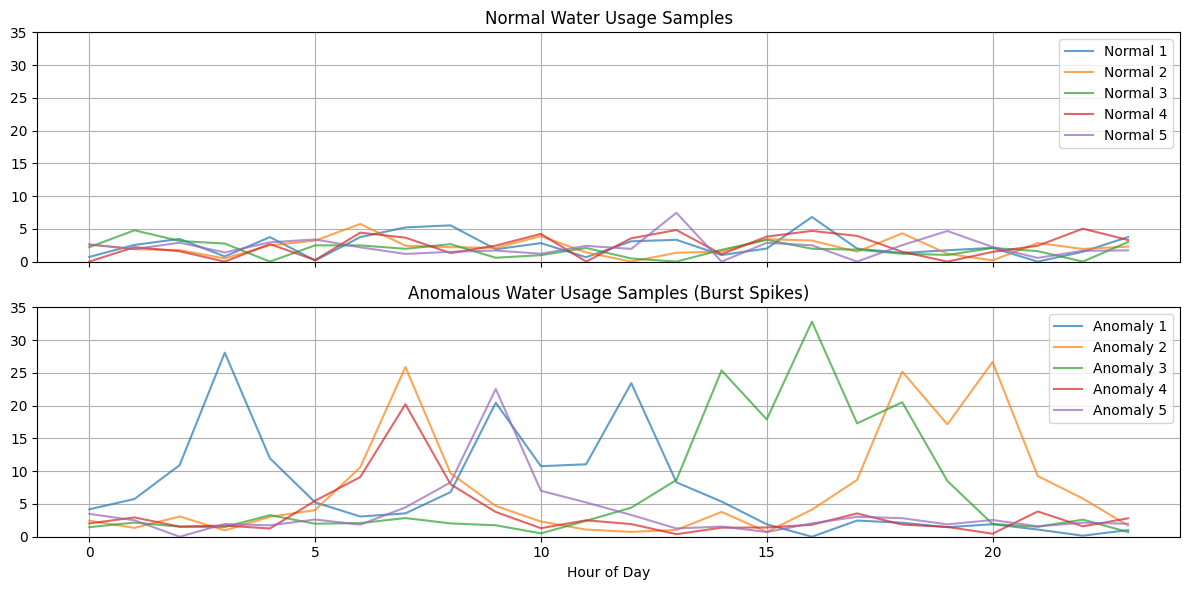

In [3]:
# Step 3 : Plot water usage data samples.

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
y_min, y_max = 0, 35

# Plot normal samples
for i in range(5):
    ax[0].plot(X[i], alpha=0.7, label=f"Normal {i+1}")
ax[0].set_title("Normal Water Usage Samples")
ax[0].set_ylim(y_min, y_max)
ax[0].legend()
ax[0].grid(True)

# Plot anomalous samples
for i in range(5):
    ax[1].plot(X[-(i+1)], alpha=0.7, label=f"Anomaly {i+1}")
ax[1].set_title("Anomalous Water Usage Samples (Burst Spikes)")
ax[1].set_ylim(y_min, y_max)
ax[1].legend()
ax[1].grid(True)

plt.xlabel("Hour of Day")
plt.tight_layout()
plt.show()

In [4]:
# Step 4 : Prepare the data.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_true, test_size=0.2, random_state=42, stratify=y_true)

X_train_tensor = torch.tensor(X_train, dtype="float32", device=device)
X_test_tensor  = torch.tensor(X_test,  dtype="float32", device=device)
y_train_tensor = torch.tensor(y_train, dtype="float32", device=device)
y_test_tensor  = torch.tensor(y_test,  dtype="float32", device=device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

In [5]:
# Step 5 : Define the anomaly-detection model.

class Autoencoder(nn.Module):
    def __init__(self, input_dim=24):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(48, 16),
            nn.ReLU(),
            nn.Linear(16, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 48),
            nn.ReLU(),
            nn.Linear(48, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder(input_dim=24)
model.to(device)

INFO - Creating Sequential model with layers:
...Layer type: LINEAR, Params: {'in_features': 24, 'out_features': 48}
...Layer type: RELU, Params: {}
...Layer type: DROPOUT, Params: {}
...Layer type: LINEAR, Params: {'in_features': 48, 'out_features': 16}
...Layer type: RELU, Params: {}
...Layer type: LINEAR, Params: {'in_features': 16, 'out_features': 4}
INFO - Creating Sequential model with layers:
...Layer type: LINEAR, Params: {'in_features': 4, 'out_features': 16}
...Layer type: RELU, Params: {}
...Layer type: LINEAR, Params: {'in_features': 16, 'out_features': 48}
...Layer type: RELU, Params: {}
...Layer type: LINEAR, Params: {'in_features': 48, 'out_features': 24}
...Layer type: SIGMOID, Params: {}


In [ ]:
# Step 6 : Train the model.

def train_autoencoder(model, train_loader, test_loader, epochs=10, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                test_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    return train_losses, test_losses

import time
start_time = time.time()
train_losses, test_losses = train_autoencoder(model, train_loader, test_loader)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

Epoch 1: Train Loss = 1.0245, Test Loss = 0.9439
Epoch 2: Train Loss = 1.0161, Test Loss = 0.9381


In [ ]:
# Step 7 : Plot training and test data.

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Autoencoder Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 8 : Run the model to detect anomalies.

def detect_anomalies(model, data_loader, threshold=None):
    model.eval()
    errors = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            batch_errors = torch.mean((outputs - inputs) ** 2, dim=1).numpy()
            errors.extend(batch_errors)
    errors = np.array(errors)
    if threshold is None:
        threshold = np.mean(errors) + 2 * np.std(errors)
    preds = (errors > threshold).astype(int)
    return preds, errors, threshold

y_pred, reconstruction_errors, threshold = detect_anomalies(model, test_loader)

In [ ]:
# Step 9 : Show the test results.
    
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("=== Anomaly Detection Results ===\n")
print(f"Threshold for classification: {threshold:.4f} (based on mean + 2*std of reconstruction error)")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix with labels
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("\nConfusion Matrix:")
print(f"                 Predicted Normal    Predicted Anomaly")
print(f"Actual Normal        {tn:>5}                 {fp:>5}")
print(f"Actual Anomaly       {fn:>5}                 {tp:>5}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))

# Plot: Reconstruction Error Distribution
# - X-axis: Reconstruction error (Mean Squared Error between input and output).
# - Y-axis: Number of samples with that error.
# - Blue histogram = Normal samples (label 0)
# - Red histogram  = Anomalies (label 1)
# - The black dashed line is the learned threshold: errors above this line are predicted as anomalies.
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors[y_test == 0], bins=50, alpha=0.6, label='Normal', color='blue')
plt.hist(reconstruction_errors[y_test == 1], bins=50, alpha=0.6, label='Anomaly', color='red')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Reconstruction Error Distribution (MSE)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()